In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pickle
import keras

from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing import sequence

Parameters

In [2]:
model_path = '../models/tc_model_1_1680891414_tt_1680888903.h5'
dictionary_path = '../data/small_dictionary_1680888160.pickle'
tokenizer_path = '../models/tokenizer_1680888903.pickle'
places_path = '../data/places_krakow_vectorized_1680900733.pickle'

The method that loads model, tokenizer, vectorized data and the dictionary

In [3]:
def load(model_path, tokenizer_path, places_path, dictionary_path):
    with open(tokenizer_path, 'rb') as file:
        tokenizer = pickle.load(file)
        
    with open(places_path, 'rb') as file:
        places = pickle.load(file)
        
    with open(dictionary_path, 'rb') as file:
        dictionary = pickle.load(file)
        dictionary = {value: key for key, value in dictionary.items()}
        
    model = keras.models.load_model(model_path)
    
    return model, tokenizer, places, dictionary

The method takes model, tokenizer & the input text to calculate the interest vector

In [4]:
def calculate_vector(model, tokenizer, text):
    sequences = tokenizer.texts_to_sequences([text])
    maxlen = model.layers[0].input_length
    x = pad_sequences(sequences, maxlen=maxlen)
    return model.predict(x, verbose=0)[0]

The methods that calculates difference between user profile and the places profiles

In [5]:
def mse(vector, place_vector):
    return np.square(vector - place_vector).mean()

In [62]:
def best_fit_weighted_avg(vector, place_vector, weights=[2, 1.5, 1.5, 1, 1]):
    best_categories = np.argsort(vector)[::-1][0:len(weights)]
    difference = np.abs(place_vector[best_categories] - vector[best_categories])
    return np.average(difference, weights=weights)

The method sorts places by the best fitting ones. It returns the following lists: sorted places, distance values

In [63]:
def sort_places(vector, places, difference_metric=mse):
    buffer = []
    for place in places:
        buffer.append((place, difference_metric(vector, place[10])))
        
    buffer.sort(key=lambda x: x[1])
    
    return zip(*buffer)

### Predict the result on given input text

Set the text for prediction

In [8]:
text = 'I really like eating in bars like that. I would like to drink more beer'

Load model & tokenizer

In [9]:
model, tokenizer, places, dictionary = load(model_path, tokenizer_path, places_path, dictionary_path)

Metal device set to: Apple M1


2023-04-07 22:53:28.639744: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-07 22:53:28.639848: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Calculate the result vector

In [64]:
result = calculate_vector(model, tokenizer, text)

Sort those places by user interests

In [65]:
places_sorted, distances = sort_places(result, places, difference_metric=best_fit_weighted_avg)

### Visualize the result

The method decodes the result vector to human readable form

In [12]:
def visualize_vector(vector, dictionary, text):
    label_weight = [(dictionary[index], weight) for index, weight in enumerate(vector)]
    label_weight.sort(key=lambda x: x[1], reverse=True)
    y, x = zip(*label_weight)
    x = np.array(x)
    x *= 100
    
    plt.figure(figsize=(10, 0.25*len(y)))
    plt.ylabel('Category')
    plt.xlabel('Weight in %')
    plt.title(f'Result for text "{text}"')

    plt.plot(x, y, 'r.', label='Category weight')
    plt.plot(x, y, 'b', label='Category weight (line)', linewidth=0.5)
    plt.xticks(np.arange(0, 101, 10))
    
    plt.legend()
    plt.show()

The method presents the sorting results

In [13]:
def visualize_places(places_sorted, distances, dictionary, text, limit=50):
    y = [f'{(place[1][:37] + "..." if len(place[1]) >= 40 else place[1])} [{dictionary[np.argmax(place[10])]}]' for place in places_sorted]
    x = np.array(distances, dtype='float64')*100
    
    if limit is not None:
        y = y[0:limit+1]
        x = x[0:limit+1]
    
    plt.figure(figsize=(10, 0.25*len(y)))
    plt.ylabel('Place name with best fitting category')
    plt.xlabel('Difference in %')
    plt.title(f'Best fitting places for text "{text}"')

    plt.plot(x, y, 'r.', label='Difference')
    plt.plot(x, y, 'b', label='Difference (line)', linewidth=0.5)
    
    max_val = np.max(x)
    plt.xticks(np.arange(0, int(np.ceil(max_val)), int(np.ceil(max_val))/10))
    
    plt.legend()
    plt.show()

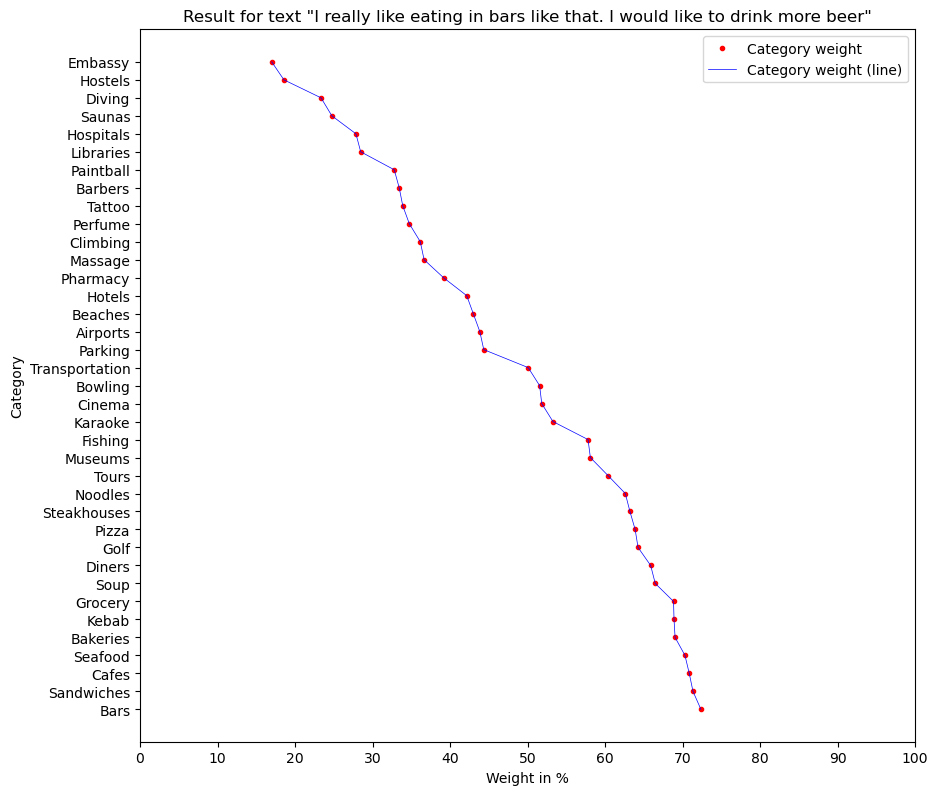

In [66]:
visualize_vector(result, dictionary, text)

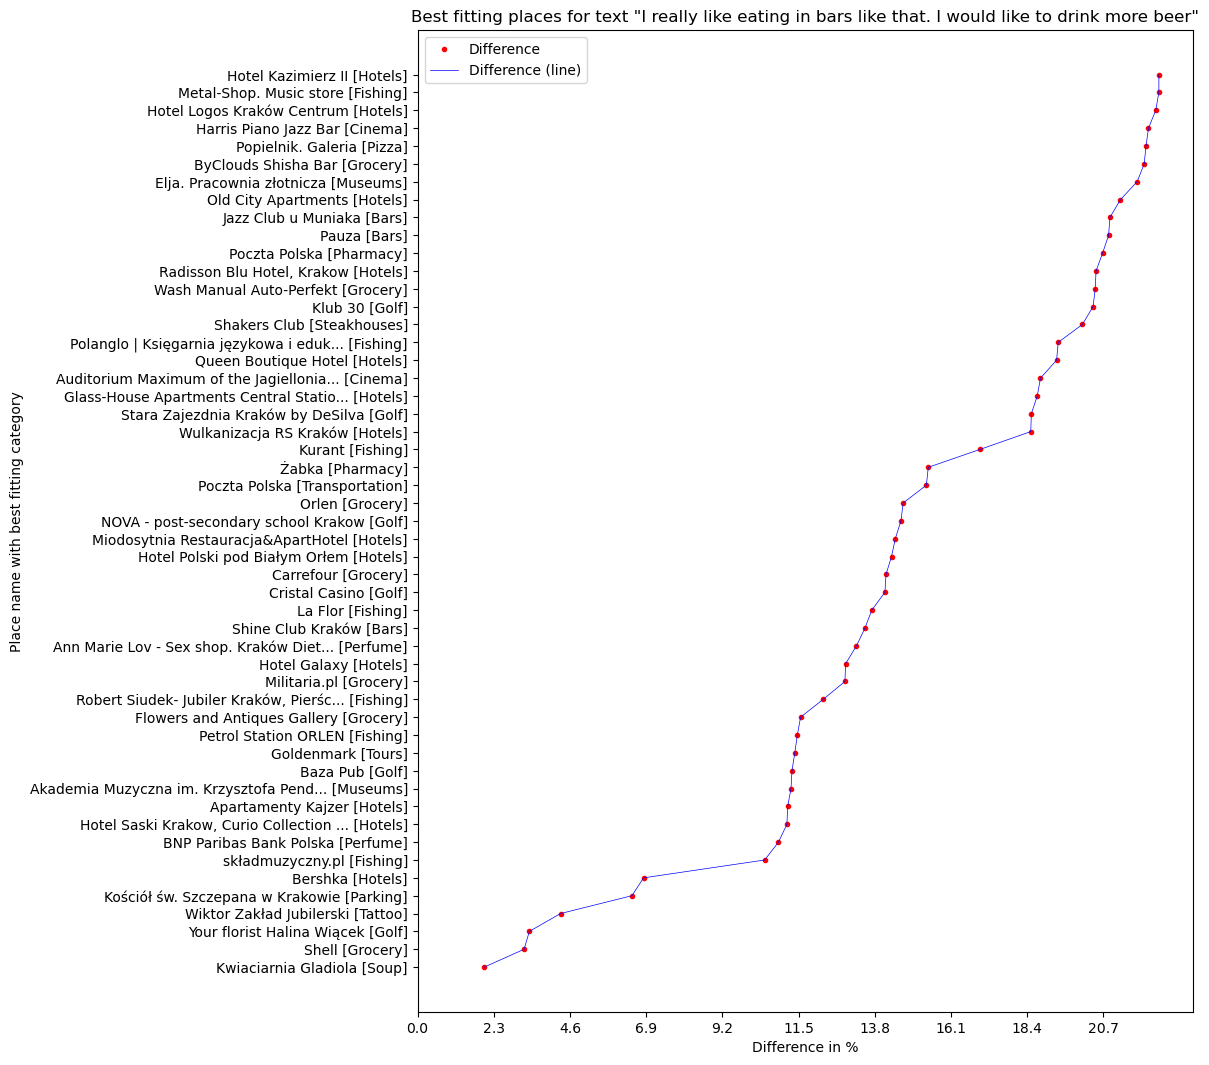

In [67]:
visualize_places(places_sorted, distances, dictionary, text)

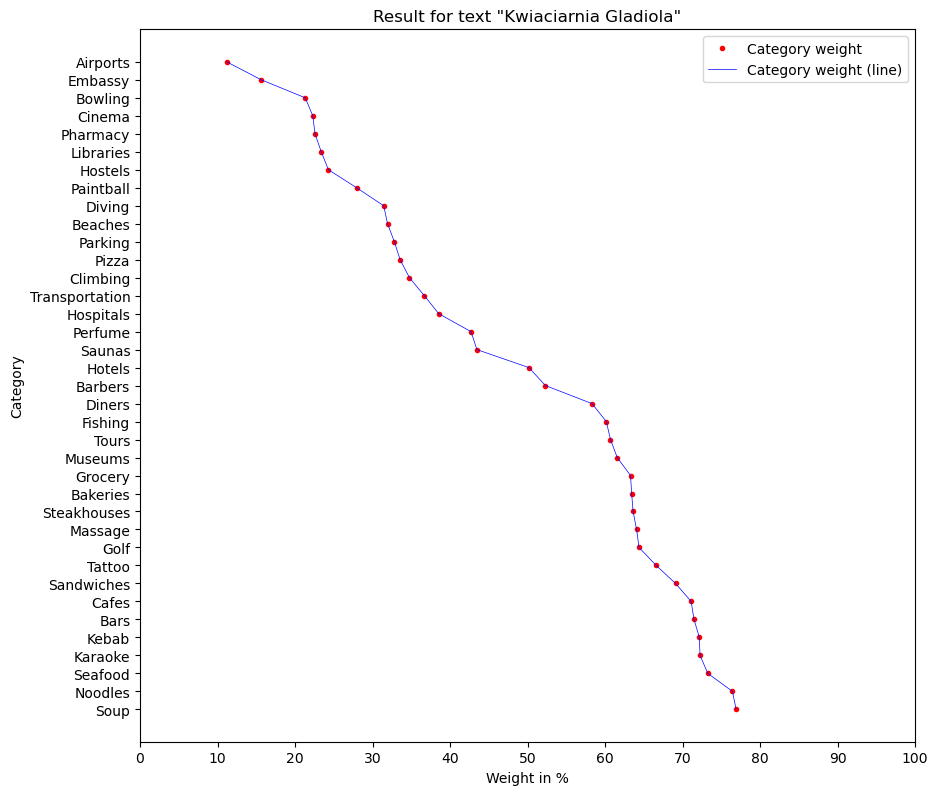

In [76]:
visualize_vector(places_sorted[0][10], dictionary, places_sorted[0][1])